#### 작업 노트북 
- feature 정리 
- 데이터 전처리
- 모델링
- 학습 및 추론
- 제품별 추천 결과 테이블

In [ ]:
%pip install pandas
%pip install scikit-learn
%pip install sqlalchemy
%pip install pymysql
%pip install konlpy
%pip install matplotlib
%pip install gensim
%pip install numpy==1.26.4

^C
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\user\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [73]:
import pandas as pd
import warnings
import re 
from model.bow import BagOfWords
from model.tfidf import TfIdf
import yaml
import matplotlib.pyplot as plt

from utils.preprocessing import *

warnings.filterwarnings("ignore")

#### Configuration
- 추천 서비스 생성을 위해서 필요한 설정값들을 세팅합니다.

In [74]:
# config
with open('configs/database.yaml') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

In [75]:
from utils.query_service import QueryService
query_service = QueryService(cfg['mysql'])

#### Data Import
- 사용할 데이터를 mysql에서 가져옵니다. 

In [76]:
query_service.query_to_pandas_df('Show tables')

,Tables_in_bakery
0,board_preference_statistic
1,board_statistic
2,food_survey
3,image
4,member
5,member_preference
6,notice
7,preference
8,product
9,product_board


In [77]:
PRODUCT_BOARD_SQL = """
SELECT id
, store_id
, title
, price
, is_soldout
, view 
FROM product_board
"""
product_board = query_service.query_to_pandas_df(PRODUCT_BOARD_SQL)

In [78]:
PRODUCT_SQL = """
SELECT id
, product_board_id
, title as option
, price as option_price
, category
, gluten_free_tag
, high_protein_tag
, sugar_free_tag
, vegan_tag
, ketogenic_tag
FROM product
"""
product = query_service.query_to_pandas_df(PRODUCT_SQL)

In [79]:
REVIEW_SQL = """
SELECT board_id
, badge_taste
, badge_brix
, badge_texture
, rate
, content
FROM review
"""
review = query_service.query_to_pandas_df(REVIEW_SQL)
review = review.drop_duplicates(subset=['board_id', 'content'], keep='first')

In [80]:
BOARD_STAT_SQL = """
SELECT board_id
, board_review_grade
, board_view_count
, board_review_count
, board_wish_count 
FROM board_statistic
"""
board_stat = query_service.query_to_pandas_df(BOARD_STAT_SQL)

In [81]:
# board_id가 각 preference_type마다 얼만큼의 preference_score를 갖는지
# 아직 신뢰성있는 데이터로 보이진 않음 (샘플이 적고 score의 분산이 너무 큼)
BOARD_PREFERENCE_STAT_SQL = """
SELECT board_id
, preference_score
, preference_type
, preference_weight
FROM board_preference_statistic
ORDER BY board_id
"""
board_preference_stat = query_service.query_to_pandas_df(BOARD_PREFERENCE_STAT_SQL)

#### Preprocessing

1. Product + Product board 데이터 기반 유사도 테이블
2. Coverage 평가 방법 수행 및 시각화
3. 후처리 고려하기

In [161]:
product.head()

,id,product_board_id,option,option_price,category,gluten_free_tag,high_protein_tag,sugar_free_tag,vegan_tag,ketogenic_tag
0,1,1,필수상품 없음,3800,CAKE,1,0,0,0,0
1,2,2,드리,5000,COOKIE,1,0,0,1,0
2,3,2,초코코코넛(넛프리),5000,COOKIE,1,0,0,1,0
3,4,2,한라봉얼그레이,5000,COOKIE,1,0,0,1,0
4,5,2,바나나피칸(제로슈가/노오일/노솔트),5000,COOKIE,1,0,0,1,0


In [162]:
product_board.head()

,id,store_id,title,price,is_soldout,view
0,1,1,냥빵 파운드 저탄수 대체당 제로 빵 글루텐프리 건강빵 비건,3800,0,0
1,2,2,비건 유기농 쌀 & 기장쌀 잡곡 비스코티 5종 미앤드리 글루텐프리,5000,1,0
2,3,3,비건이레 비건케이크 글루텐프리 떠먹는케이크 얼그레이아몬드베린느 GF,7500,0,0
3,4,4,프로넛 무설탕 자일리톨 캔디 레몬 선물 사탕 금연 양치 아이간식 어린이집,2800,0,0
4,5,5,꾸디 비건쿠키 (르뱅쿠키 수제쿠키),4200,0,0


In [213]:
review.head()

,board_id,badge_taste,badge_brix,badge_texture,rate,content
0,178,GOOD,NULL,NULL,3.0,일단 크기는 굉장히 작아요 성분이 괜찮아서 구매했는데 저는 그냥 한번 먹어본걸로 만...
1,178,NULL,NULL,NULL,5.0,좋은 빵 많이 만들어주세요
2,178,NULL,NULL,NULL,5.0,건강한 상품 잘 먹겠습니다
3,178,GOOD,NULL,NULL,5.0,너무 맛있어요성분도 좋구요크기가 너무 작아서계속 먹게되네요ㅋ
4,178,NULL,NULL,NULL,5.0,배송 좋았습니다. 고객센터 전화도 잘 되구요


In [214]:
sold_out = product_board[product_board['is_soldout']==1]['store_id'].unique()

In [215]:
grouped = product.groupby('product_board_id').agg({
    'id': 'first',
    'option': ' '.join, # option을 공백을 두고 이어 붙임
    'option_price': 'first',
    'category': 'first',
    'gluten_free_tag': 'first',
    'high_protein_tag': 'first',
    'sugar_free_tag': 'first',
    'vegan_tag': 'first',
    'ketogenic_tag': 'first',
})


df = grouped.copy()

df['id'] = df.index

df.shape

(209, 9)

In [216]:
product_board

,id,store_id,title,price,is_soldout,view
0,1,1,냥빵 파운드 저탄수 대체당 제로 빵 글루텐프리 건강빵 비건,3800,0,0
1,2,2,비건 유기농 쌀 & 기장쌀 잡곡 비스코티 5종 미앤드리 글루텐프리,5000,1,0
2,3,3,비건이레 비건케이크 글루텐프리 떠먹는케이크 얼그레이아몬드베린느 GF,7500,0,0
3,4,4,프로넛 무설탕 자일리톨 캔디 레몬 선물 사탕 금연 양치 아이간식 어린이집,2800,0,0
4,5,5,꾸디 비건쿠키 (르뱅쿠키 수제쿠키),4200,0,0
...,...,...,...,...,...,...
206,207,9,로썸 통밀비스코티,4500,0,0
207,208,32,빵떡집 단백질빵떡이 단백질10g 글루텐프리,3500,0,0
208,209,6,[소소한 소금빵 4개 세트] 비건빵 100% 건강빵 간식,11000,0,0
209,210,22,[포포브레드] 마들렌 4종 / 쌀 디저트 글루텐프리 노밀가루 비건 베이커리,2800,0,0


In [217]:
"""
grouped = product_board.groupby('id').agg({
    'title': ' '.join  # title을 공백을 두고 이어 붙임
})


df_board = grouped.copy()


df_board['id'] = df_board.index

df_board.shape
"""

"\ngrouped = product_board.groupby('id').agg({\n    'title': ' '.join  # title을 공백을 두고 이어 붙임\n})\n\n\ndf_board = grouped.copy()\n\n\ndf_board['id'] = df_board.index\n\ndf_board.shape\n"

In [218]:
#review = review.loc[review['rate']>3, :].copy()

grouped = review.groupby('board_id').agg({
    'rate': 'mean',
    'content': ' '.join  # content을 공백을 두고 이어 붙임
})


df_review = grouped.copy()


df_review['id'] = df_review.index

df_review.shape

(154, 3)

In [219]:
df = df[['id', 'option', 'option_price', 'category', 'gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']].copy()

#df = df.drop_duplicates()
#df = df.dropna()

df['option'] = df['option'].fillna('')
df.loc[df['option'] == '필수상품 없음', 'option'] = ''

In [220]:
# 두 데이터프레임을 store_id (df_board)와 product_board_id (df) 기준으로 병합
merged_df = pd.merge(df, product_board, left_on='id', right_on='id', how='left')
merged_df = pd.merge(merged_df, df_review, left_on = 'id', right_on='id', how='left')
df = merged_df.copy()

In [222]:
df['store_id']

0       1
1       2
2       3
3       4
4       5
       ..
204     9
205    32
206     6
207    22
208     7
Name: store_id, Length: 209, dtype: int64

In [223]:
# Create the new soup feature
df['title'] = df.apply(create_title, axis=1)

In [224]:
from konlpy.tag import Okt
import pandas as pd



# title에 공백 추가
df['title_with_spaces'], df['title_nouns_list'] = zip(*df['title'].apply(add_spaces))

In [225]:
df[df['title_with_spaces']=='']

,id,option,option_price,category,gluten_free_tag,high_protein_tag,sugar_free_tag,vegan_tag,ketogenic_tag,store_id,title,price,is_soldout,view,rate,content,title_with_spaces,title_nouns_list
5,6,,27500,ETC,0,0,0,1,0,6,[쌀낭시에 5종x2개입] 비건빵 글루텐프리 쌀빵 휘낭시에 건강간식 널 테스트,27500,0,0,5.0,널 테스트,,[]
46,47,,13750,ETC,0,0,0,1,0,6,[클래식 단팥빵 5개 세트] 비건빵 100% 건강빵 영양 간식 더브레드블루 nan,13750,0,0,NaN,NaN,,[]
48,49,,28100,ETC,0,0,0,1,0,6,[더브레드블루 간식빵 6종 맛보기 세트] 비건빵 100% 건강빵 생일선물 6종 구...,28100,0,0,4.0,6종 구성이 알차요,,[]
75,76,,6000,CAKE,0,0,0,1,0,6,[달콤 통밀 크럼블] 더브레드블루 비건빵 건강간식 통밀 건강 식사대용 nan,6000,0,0,NaN,NaN,,[]
113,114,,27500,ETC,0,0,0,1,0,6,[소소한 소금빵 10개 세트] 비건빵 100% 건강빵 간식 nan,27500,0,0,NaN,NaN,,[]
163,166,,15000,ETC,0,0,1,1,1,6,[통밀100] 비건빵 100% 통밀빵 샌드위치 파니니 식사대용 건강 간식 nan,15000,0,0,NaN,NaN,,[]
206,209,,11000,ETC,0,0,0,1,0,6,[소소한 소금빵 4개 세트] 비건빵 100% 건강빵 간식 nan,11000,0,0,NaN,NaN,,[]


In [226]:
features = ['gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']

for feature in features:
  df[feature] = df[feature].apply(lambda x: x*feature)

In [227]:
"""
bins = [0, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000, 200000]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
df['option_price'] = pd.cut(df['option_price'], bins = bins, labels = labels, include_lowest = True)
plt.hist(df['option_price'].apply(lambda x: int(x)))
"""

"\nbins = [0, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000, 200000]\nlabels = ['1', '2', '3', '4', '5', '6', '7', '8', '9']\ndf['option_price'] = pd.cut(df['option_price'], bins = bins, labels = labels, include_lowest = True)\nplt.hist(df['option_price'].apply(lambda x: int(x)))\n"

In [228]:
# Removes spaces and converts to lowercase
# Apply the generate_list function to cast, keywords, and director
for feature in ['category', 'gluten_free_tag', 'high_protein_tag', 'sugar_free_tag', 'vegan_tag', 'ketogenic_tag']:
    df[feature] = df[feature].apply(sanitize)

In [229]:
# Create the new soup feature
df['soup'] = df.apply(create_soup, axis=1)

#### Modeling(CountVec+TF-IDF)

In [230]:
# TfIdfVectorizer 가져오기
from sklearn.feature_extraction.text import TfidfVectorizer

# 불용어를 english로 지정하고 tf-idf 계산
# stop_words='english' 옵션은 영어의 불용어(예: the, and, is 등)를 제외
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['title_with_spaces'])

# Cosine 유사도 계산, overview기반으로 영화간 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_tf = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_tf = pd.DataFrame(cosine_sim_tf, index=df.index, columns=df.index)

cosine_sim_tf.shape


(209, 209)

In [231]:
# Import CountVectorizer from the scikit-learn library
from sklearn.feature_extraction.text import CountVectorizer

# Define a new CountVectorizer object and create vectors for the soup
count = CountVectorizer(stop_words='english')
# 상품*해당 단어가 있는지 카운트 벡터
count_matrix = count.fit_transform(df['soup'])

# Cosine 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_cv = cosine_similarity(count_matrix, count_matrix)
cosine_sim_cv = pd.DataFrame(cosine_sim_cv, index=df.index, columns=df.index)

cosine_sim_cv.shape

(209, 209)

##### 1. Weighted Sum

In [232]:
cosine_sim_tf

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
0,1.000000,0.026200,0.088231,0.058960,0.143775,0.0,0.242989,0.427044,0.154534,0.175346,...,0.119482,0.238140,0.030511,0.106180,0.201505,0.174897,0.224727,0.0,0.238654,0.129098
1,0.026200,1.000000,0.113219,0.000000,0.153690,0.0,0.335569,0.000000,0.042041,0.026485,...,0.057280,0.085369,0.263005,0.246750,0.326724,0.169916,0.053701,0.0,0.161933,0.061890
2,0.088231,0.113219,1.000000,0.000000,0.415311,0.0,0.488315,0.195698,0.084980,0.266665,...,0.129855,0.316836,0.294974,0.124199,0.211118,0.180327,0.116374,0.0,0.171436,0.183574
3,0.058960,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.052881,...,0.053628,0.072406,0.000000,0.000000,0.154938,0.000000,0.000000,0.0,0.183502,0.057944
4,0.143775,0.153690,0.415311,0.000000,1.000000,0.0,0.358133,0.191982,0.055728,0.211180,...,0.075928,0.366108,0.093987,0.327080,0.101845,0.215108,0.260353,0.0,0.120621,0.082039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.174897,0.169916,0.180327,0.000000,0.215108,0.0,0.160466,0.307919,0.000000,0.056308,...,0.057104,0.214782,0.197874,0.173717,0.214418,1.000000,0.060496,0.0,0.064064,0.061699
205,0.224727,0.053701,0.116374,0.000000,0.260353,0.0,0.194255,0.234105,0.148910,0.160944,...,0.278798,0.000000,0.062537,0.217634,0.115863,0.060496,1.000000,0.0,0.137223,0.252171
206,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
207,0.238654,0.161933,0.171436,0.183502,0.120621,0.0,0.204313,0.219308,0.336845,0.318648,...,0.309083,0.219606,0.105970,0.368782,0.508574,0.064064,0.137223,0.0,1.000000,0.224234


In [233]:
cosine_sim = cosine_sim_cv*0.2 + cosine_sim_tf*0.8

In [234]:
for i in range(0, len(cosine_sim_tf)):
    for j in range(0, len(cosine_sim_tf)):
        if cosine_sim_tf.iloc[i, j] < 0.5 and cosine_sim_cv.iloc[i, j] >= 0.5:
            cosine_sim.iloc[i, j] = cosine_sim_cv.iloc[i, j].copy()
        else:
            continue

In [237]:
# Index에 product_board_id 추가
df['product_board_id'] = df['id'].copy()

# index-product_board_id을 뒤집는다
indices = pd.Series(df.index, index=df['product_board_id'])

# 상품제목을 받아서 추천 영화를 돌려주는 함수
def content_recommender(product_board_id, n_of_recomm, sold_out):
    # product_board_id에서 영화 index 받아오기
    idx = indices[product_board_id]
    # 주어진 상품과 다른 상품의 similarity를 가져온다
    sim_scores = cosine_sim[idx]
    # sold_out 후처리
    sim_scores[sold_out] = 0
    # similarity 기준으로 정렬하고 n_of_recomm만큼 가져오기 (자기자신은 빼기)
    sim_scores = sim_scores.sort_values(ascending=False)[1:n_of_recomm+1]
    # 상품 product_board_id 반환
    
    return [df.loc[sim_scores.index]['product_board_id'].values, sim_scores.values, df.loc[sim_scores.index]['store_id'].values]

# 추천받기
print(content_recommender(100, 10, sold_out))

[array([117,  62, 191, 121,  34,  36,  90,  89, 171,  87], dtype=int64), array([0.8660254 , 0.81649658, 0.81649658, 0.81649658, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 0.66666667, 0.66666667]), array([12, 12, 12, 12, 12, 12, 22, 27, 12, 12], dtype=int64)]


##### 2. Rank Aggreation

In [33]:
from scipy.stats import rankdata

count_ranking = rankdata(-cosine_sim_cv, axis = 1)
tfidf_ranking = rankdata(-cosine_sim_tf, axis = 1)

final_ranking = count_ranking + tfidf_ranking

final_ranking

array([[  2. , 276. , 127. , ..., 336.5, 105. , 247.5],
       [310.5,   3.5, 169. , ..., 284. , 105.5, 290. ],
       [171.5, 189.5,   2. , ..., 315.5, 102.5, 301.5],
       ...,
       [280.5, 202.5, 202.5, ..., 106. , 145.5, 280.5],
       [234. , 166.5, 173.5, ..., 288. ,   2. , 302. ],
       [201. , 230. , 209. , ..., 277. , 168. ,   2. ]])

In [34]:
# Index에 product_board_id 추가
df['product_board_id'] = df.index

# index-product_board_id을 뒤집는다
indices = pd.Series(df.index, index=df['product_board_id'])

# 상품제목을 받아서 추천 영화를 돌려주는 함수
def content_recommender_rank(product_board_id, n_of_recomm, sold_out):
    # product_board_id에서 영화 index 받아오기
    idx = indices[product_board_id]
    # 주어진 상품과 다른 상품의 similarity를 가져온다
    final_ranking_ = pd.DataFrame(final_ranking)
    final_ranking_ = final_ranking_[idx]
    # sold_out 후처리
    final_ranking_[sold_out] = 0
    # similarity 기준으로 정렬 
    final_ranking_ = final_ranking_.sort_values(ascending=False)[1:n_of_recomm+1]

    # 상품 product_board_id 반환    
    return [df.loc[final_ranking_.index]['product_board_id'].values, final_ranking_.values]

# 추천받기
print(content_recommender(100, 10, sold_out))

[array([120, 169,  78, 196, 178,  71, 170,  11, 123, 207], dtype=int64), array([0.68000631, 0.61044349, 0.59406663, 0.59357833, 0.58080296,
       0.55559659, 0.54223963, 0.53530845, 0.53198655, 0.53112033])]


#### Training(Word2Vec)

In [125]:
dataset = df.copy()
dataset = df['title_nouns_list'].to_dict() 

##### 1. Pre-trained + Fine-tuning

In [139]:
import gensim
from gensim.models import Word2Vec

# 사전학습 모델 불러오기
word2vec_model_path = "./korean_word2vec_model.model"  # Update with your actual path
embedding_model = gensim.models.Word2Vec.load(word2vec_model_path)

In [140]:
# 데이터셋의 모든 콘텐츠 키워드를 시퀀스로 변환
content_data = list(dataset.values())

embedding_model.build_vocab(content_data, update=True)

In [141]:
content_data

[['머핀', '카카오', '설탕', '무화과', '파운드', '레몬', '단호박', '다이어트', '버터', '비건', '냥빵', '쑥'],
 ['카카오',
  '바나나',
  '초코',
  '한라봉',
  '쿠키',
  '오렌지',
  '말차',
  '유기농',
  '브라우니',
  '코코넛',
  '스콘',
  '치즈케이크',
  '피칸',
  '비건',
  '얼그레이'],
 ['다이어트',
  '블루베리',
  '라즈베리',
  '크림',
  '콜레스테롤',
  '쿠키',
  '베리',
  '무화과',
  '비건',
  '쑥',
  '헤이즐넛',
  '아몬드',
  '번',
  '파운드',
  '스콘',
  '푸딩',
  '얼그레이',
  '딸기',
  '초코',
  '체리',
  '말차',
  '티라미수',
  '버터',
  '초콜릿'],
 ['페퍼민트', '자일리톨', '카카오', '설탕', '레몬', '파운드', '복숭아', '도넛'],
 ['카라멜', '번', '초코', '쿠키', '베리', '말차', '무화과', '단호박', '비건', '블루베리', '라즈베리'],
 ['저당',
  '바게트',
  '베이글',
  '초코',
  '치아바타',
  '식빵',
  '쿠키',
  '초콜릿',
  '크림',
  '무화과',
  '다이어트',
  '버터',
  '소보로빵',
  '비건',
  '야채'],
 ['저당',
  '블루베리',
  '라즈베리',
  '크림',
  '설탕',
  '쿠키',
  '무화과',
  '피칸',
  '비건',
  '카카오',
  '아몬드',
  '번',
  '단호박',
  '얼그레이',
  '딸기',
  '초코',
  '체리',
  '말차',
  '브라우니',
  '버터',
  '초콜릿'],
 ['베이글',
  '크림',
  '설탕',
  '쿠키',
  '수능',
  '무화과',
  '파운드',
  '다이어트',
  '치즈케이크',
  '스콘',
  '버터',
  '초콜릿',
  '비건'],
 ['식빵', '쿠키', '다이

In [142]:


# Word2Vec 모델 미세조정 학습
embedding_model.train(content_data, total_examples=embedding_model.corpus_count, epochs=5)



(1879, 7065)

In [143]:
import numpy as np

# 각 아이템을 벡터화하여 아이템 임베딩 계산
def get_item_embedding(item_keywords, model):
    # 각 키워드의 임베딩 벡터를 가져와 평균을 계산
    vectors = [model.wv[keyword] for keyword in item_keywords if keyword in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# 모든 아이템 임베딩 저장
item_embeddings = {item: get_item_embedding(keywords, embedding_model) for item, keywords in dataset.items()}


In [144]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar_items(target_item, item_embeddings, topn=3):
    """
    주어진 아이템과 유사한 아이템을 추천합니다.
    
    :param target_item: 추천 대상 아이템 ID
    :param item_embeddings: 아이템 임베딩 딕셔너리
    :param topn: 추천할 아이템 수
    :return: 유사한 아이템 리스트
    """
    target_embedding = item_embeddings[target_item].reshape(1, -1)
    similarities = {}
    
    for item, embedding in item_embeddings.items():
        if item != target_item:  # 대상 아이템 제외
            sim_score = cosine_similarity(target_embedding, embedding.reshape(1, -1)).flatten()[0]
            similarities[item] = sim_score

           
    # 유사도에 따라 정렬하고 상위 n개 반환
    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    #print(pd.DataFrame(similar_items))

    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:topn]
    
    
    return [item[0] for item in similar_items]

    

# 예시: 찜한 상품의 id와 유사한 아이템 추천
similar_items = recommend_similar_items(1, item_embeddings)
print("Similar items:", similar_items)

Similar items: [30, 141, 66]


##### 2. Just Training

In [132]:
from gensim.models import Word2Vec

# 데이터셋의 모든 콘텐츠 키워드를 시퀀스로 변환
content_data = list(dataset.values())

# Word2Vec 모델 학습
embedding_model = Word2Vec(content_data, vector_size=20, window=5, min_count=1, workers=4, sg=1, epochs=100)


In [133]:
import numpy as np

# 각 아이템을 벡터화하여 아이템 임베딩 계산
def get_item_embedding(item_keywords, model):
    # 각 키워드의 임베딩 벡터를 가져와 평균을 계산
    vectors = [model.wv[keyword] for keyword in item_keywords if keyword in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# 모든 아이템 임베딩 저장
item_embeddings = {item: get_item_embedding(keywords, embedding_model) for item, keywords in dataset.items()}


In [134]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_similar_items(target_item, item_embeddings, topn=3):
    """
    주어진 아이템과 유사한 아이템을 추천합니다.
    
    :param target_item: 추천 대상 아이템 ID
    :param item_embeddings: 아이템 임베딩 딕셔너리
    :param topn: 추천할 아이템 수
    :return: 유사한 아이템 리스트
    """
    target_embedding = item_embeddings[target_item].reshape(1, -1)
    similarities = {}
    
    for item, embedding in item_embeddings.items():
        if item != target_item:  # 대상 아이템 제외
            sim_score = cosine_similarity(target_embedding, embedding.reshape(1, -1)).flatten()[0]
            similarities[item] = sim_score

           
    # 유사도에 따라 정렬하고 상위 n개 반환
    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    #print(pd.DataFrame(similar_items))

    similar_items = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:topn]
    
    
    return [item[0] for item in similar_items]

    

# 예시: 찜한 상품의 id와 유사한 아이템 추천
similar_items = recommend_similar_items(1, item_embeddings)
print("Similar items:", similar_items)

Similar items: [30, 157, 192]


#### Evaluating

##### 1-1. CountVec + TF-IDF

In [246]:
store_ids = [1, 2, 3]
store_id =  1


In [247]:
[1 for i in store_ids if i == store_id]

[1]

In [288]:
# 같은 스토어 상품 추천 개수
recommended_stores = []
recommended_stores_ = []

for i in df.product_board_id.values:
    recommended_stores_ = []
    test = content_recommender(i, 3, sold_out)
    recommended_stores_.extend(test[2])
    recommended_stores.extend([1 for store_id in store_ids if store_id == i])
    #print(recommended_stores)
    
print(sum(recommended_stores)/len(df.product_board_id.values)*3*100,"%")


4.30622009569378 %


In [253]:
recommended_items = []

for i in df.product_board_id.values:
    test = content_recommender(i, 3, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))

In [254]:
from metrics.coverage import get_coverage

n_items = cosine_sim.shape[0]

get_coverage(recommended_items, n_items)

0.8851674641148325

(array([12.,  3.,  5.,  3.,  4.,  3.,  7.,  4.,  5.,  8.,  4.,  9.,  9.,
         8.,  6., 12.,  3., 11.,  4.,  4.,  6.,  4.,  4.,  5.,  6.,  5.,
         4.,  6.,  8., 22.,  9.,  3.,  4.,  3.,  3.,  8.,  8.,  7.,  6.,
         5.,  5., 28.,  1.,  6.,  8.,  5.,  4.,  3.,  5.,  8.,  0.,  5.,
         1.,  6.,  4.,  7.,  4., 16.,  4.,  7.,  7.,  6.,  8.,  1.,  9.,
         6.,  7.,  2.,  5.,  5.,  0.,  8.,  7.,  5.,  8.,  6.,  6.,  8.,
         8.,  2.,  5.,  5.,  7.,  9.,  8., 13.,  5.,  3.,  7.,  9., 19.,
         2.,  5.,  5.,  9.,  2.,  6.,  7.,  6.,  4.]),
 array([  1.  ,   3.09,   5.18,   7.27,   9.36,  11.45,  13.54,  15.63,
         17.72,  19.81,  21.9 ,  23.99,  26.08,  28.17,  30.26,  32.35,
         34.44,  36.53,  38.62,  40.71,  42.8 ,  44.89,  46.98,  49.07,
         51.16,  53.25,  55.34,  57.43,  59.52,  61.61,  63.7 ,  65.79,
         67.88,  69.97,  72.06,  74.15,  76.24,  78.33,  80.42,  82.51,
         84.6 ,  86.69,  88.78,  90.87,  92.96,  95.05,  97.14,  99.23,
  

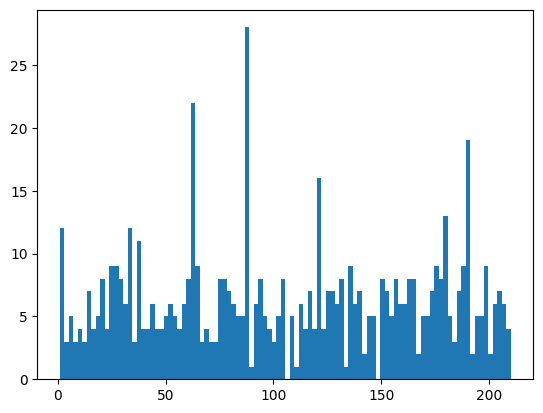

In [264]:
plt.hist(recommended_items, bins = 100)

##### 1-2. CountVec + TF-IDF Rank Aggreation

In [49]:
recommended_items = []

for i in range(0, 209):
    test = content_recommender_rank(i, 3, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))

In [50]:
from metrics.coverage import get_coverage

n_items = cosine_sim.shape[0]

get_coverage(recommended_items, n_items)

0.7129186602870813

##### 2. Word2Vec

In [145]:
recommended_items = []

for i in range(0, 209):
    test = recommend_similar_items(i, item_embeddings)
    recommended_items.extend(str(test[0]))


recommended_items = list(map(lambda x: int(x), recommended_items))

In [146]:
from metrics.coverage import get_coverage

n_items = len(item_embeddings)

get_coverage(recommended_items, n_items)

0.04784688995215311

#### INFERENCE

##### 1. CountVec + TF-IDF

In [265]:
case_1, _, _ = content_recommender(1, 3, sold_out)

In [266]:
df[df['product_board_id'].isin(case_1)]

,id,option,option_price,category,gluten_free_tag,high_protein_tag,sugar_free_tag,vegan_tag,ketogenic_tag,store_id,title,price,is_soldout,view,rate,content,title_with_spaces,title_nouns_list,soup,product_board_id
90,91,헤이즐넛 버터바 황치즈 버터바 (+200원) 말차 버터바 얼그레이 버터바,3800,etc,gluten_free_tag,,,,,8,헤이즐넛 버터바 황치즈 버터바 (+200원) 말차 버터바 얼그레이 버터바 [모닐이네...,3800,0,0,4.900000,₊·*◟(⌯ˇ- ˇ⌯)◜‧*･최고 맛집입니당❥❥❥ 여기는 오히려 날 추울때보다 여름...,번 말차 부드러움 버터 얼그레이 헤이즐넛,"[번, 말차, 부드러움, 버터, 얼그레이, 헤이즐넛]",3800 etc gluten_free_tag,91
94,95,다크(무설탕) 얼그레이(무설탕) 말차(무설탕) 몽블랑(무설탕) 헤이즐넛 다크(무설탕...,29500,cake,gluten_free_tag,,,,,8,다크(무설탕) 얼그레이(무설탕) 말차(무설탕) 몽블랑(무설탕) 헤이즐넛 다크(무설탕...,29500,0,0,NaN,NaN,얼그레이 설탕 티라미수 말차 초콜릿 라즈베리 헤이즐넛,"[얼그레이, 설탕, 티라미수, 말차, 초콜릿, 라즈베리, 헤이즐넛]",29500 cake gluten_free_tag,95
177,180,대파 치즈 무화과 고르곤졸라,3800,cake,gluten_free_tag,high_protein_tag,sugar_free_tag,,,10,대파 치즈 무화과 고르곤졸라 키토빵앗간 디쉬 치즈 스콘 (저당 글루텐프리 저탄수빵)...,3800,0,0,4.858025,있었는데? 없어짐…약없이 관리중인 1.5형인데 요즘 너무나도 바빠서 도시락 싸거나 ...,저당 번 크림 설탕 쿠키 무화과 다이어트 스콘,"[저당, 번, 크림, 설탕, 쿠키, 무화과, 다이어트, 스콘]",3800 cake gluten_free_tag high_protein_tag sug...,180


In [267]:
case_2, _, _ = content_recommender(100, 3, sold_out)

In [268]:
df[df['product_board_id'].isin(case_2)]

,id,option,option_price,category,gluten_free_tag,high_protein_tag,sugar_free_tag,vegan_tag,ketogenic_tag,store_id,title,price,is_soldout,view,rate,content,title_with_spaces,title_nouns_list,soup,product_board_id
61,62,,0,etc,gluten_free_tag,,,vegan_tag,,12,미니 발로나 초코 브라우니 nan,3900,0,0,NaN,NaN,브라우니 초코,"[브라우니, 초코]",0 etc gluten_free_tag vegan_tag,62
116,117,식빵 종류 구름식빵 꼬소구름식빵 (+700원) 베리구름식빵 (+500원),9500,bread,gluten_free_tag,,,vegan_tag,,12,식빵 종류 구름식빵 꼬소구름식빵 (+700원) 베리구름식빵 (+500원) 토스트 다...,9500,0,0,4.846154,토스트 해먹으니 좋네요 아이가 너무 잘먹습니다 정말 단단한 글루텐프리식빵이에요포만감...,식빵 베리 다이어트 버터 비건 라즈베리,"[식빵, 베리, 다이어트, 버터, 비건, 라즈베리]",9500 bread gluten_free_tag vegan_tag,117
188,191,,0,etc,gluten_free_tag,,,vegan_tag,,12,비건 쌀 마들렌 - 콩고물 범벅 쑥 nan,4200,0,0,NaN,NaN,비건 마들렌 쑥,"[비건, 마들렌, 쑥]",0 etc gluten_free_tag vegan_tag,191


In [269]:
case_3, _, _ = content_recommender(200, 3, sold_out)

In [270]:
df[df['product_board_id'].isin(case_3)]

,id,option,option_price,category,gluten_free_tag,high_protein_tag,sugar_free_tag,vegan_tag,ketogenic_tag,store_id,title,price,is_soldout,view,rate,content,title_with_spaces,title_nouns_list,soup,product_board_id
0,1,,3800,cake,gluten_free_tag,,,,,1,냥빵 파운드 저탄수 대체당 제로 빵 글루텐프리 건강빵 비건 시어머니 드렸는데 아주...,3800,0,0,4.951613,시어머니 드렸는데 아주 맛있게 드셨다고 합니다.성분도 좋고 식감도 좋고 맛있습니다^...,설탕 무화과 파운드 단호박 다이어트 버터 비건 냥빵 쑥,"[설탕, 무화과, 파운드, 단호박, 다이어트, 버터, 비건, 냥빵, 쑥]",3800 cake gluten_free_tag,1
38,39,바닐라 바치케 초코 바치케 (+500원) 말차 바치케 (+500원) 모카 바치케 (...,14500,cake,gluten_free_tag,,,,,8,바닐라 바치케 초코 바치케 (+500원) 말차 바치케 (+500원) 모카 바치케 (...,14500,0,0,4.916667,BEST덕분에 즐거운 생일이 되었습니다. 꾸덕하고 맛이 진해서 맛있었어요. BEST...,초코 설탕 치즈케이크 말차,"[초코, 설탕, 치즈케이크, 말차]",14500 cake gluten_free_tag,39
172,175,플레인 헤이즐넛 (+200원) 발로나(프랑스) 초코 (+200원) 보늬밤 (+400...,2800,cake,gluten_free_tag,,,,,8,플레인 헤이즐넛 (+200원) 발로나(프랑스) 초코 (+200원) 보늬밤 (+400...,2800,0,0,4.972973,BEST꾸덕 쫀득 맛있어요다만 버터의 풍미가 좀 더 있으면 좋겠는데 인터넷으로 시키...,초코 크림 쿠키 말차 무화과 파운드 다이어트 버터 초콜릿 블루베리 헤이즐넛,"[초코, 크림, 쿠키, 말차, 무화과, 파운드, 다이어트, 버터, 초콜릿, 블루베리...",2800 cake gluten_free_tag,175


##### 2. Word2Vec

In [118]:
recommend_similar_items(3, item_embeddings)

NameError: name 'recommend_similar_items' is not defined

#### SAVE

In [119]:
import pandas as pd
from datetime import datetime

In [120]:

query_item = df.index.values.repeat(3)

recommended_items = []

for i in range(0, 209):
    test = content_recommender(i, 3, sold_out)
    recommended_items.extend(test[0])


recommended_items = list(map(lambda x: int(x), recommended_items))


score = []

for i in range(0, 209):
    test = content_recommender(i, 3, sold_out)
    score.extend(test[1])


score = list(map(lambda x: float(x), score))


rank = [1, 2, 3]*cosine_sim.shape[0]

recommendation_theme = ['similarity']*cosine_sim.shape[0]*3

model_version = ['bow-1+TF-IDF']*cosine_sim.shape[0]*3

created_at = [datetime.now()]*cosine_sim.shape[0]*3

modified_at = [datetime.now()]*cosine_sim.shape[0]*3

#### 추천 결과 테이블 포맷
- query item은 찜이 눌린 아이템입니다.
- recommendation item은 query 아이템 당 3개를 추출합니다.
- 유사한 recommendation item이 없을 경우 랜덤한 3개의 결과를 추천합니다.
- 포맷에 맞게 데이터프레임을 만듭니다. 

In [121]:
import pandas as pd
from datetime import datetime
data = {
    'query_item': query_item,
    'recommendation_item': recommended_items,
    'score': score,
    'rank': rank,
    'recommendation_theme': recommendation_theme,
    'model_version': model_version,
    'created_at': created_at,
    'modified_at': modified_at
}

recommendation_df = pd.DataFrame(data)


In [122]:
recommendation_df

,query_item,recommendation_item,score,rank,recommendation_theme,model_version,created_at,modified_at
0,0,90,0.816497,1,similarity,bow-1+TF-IDF,2024-11-07 09:51:38.591952,2024-11-07 09:51:38.591952
1,0,177,0.774597,2,similarity,bow-1+TF-IDF,2024-11-07 09:51:38.591952,2024-11-07 09:51:38.591952
2,0,129,0.666667,3,similarity,bow-1+TF-IDF,2024-11-07 09:51:38.591952,2024-11-07 09:51:38.591952
3,1,64,1.000000,1,similarity,bow-1+TF-IDF,2024-11-07 09:51:38.591952,2024-11-07 09:51:38.591952
4,1,149,1.000000,2,similarity,bow-1+TF-IDF,2024-11-07 09:51:38.591952,2024-11-07 09:51:38.591952
...,...,...,...,...,...,...,...,...
622,207,188,0.816497,2,similarity,bow-1+TF-IDF,2024-11-07 09:51:38.591952,2024-11-07 09:51:38.591952
623,207,120,0.816497,3,similarity,bow-1+TF-IDF,2024-11-07 09:51:38.591952,2024-11-07 09:51:38.591952
624,208,19,0.544190,1,similarity,bow-1+TF-IDF,2024-11-07 09:51:38.591952,2024-11-07 09:51:38.591952
625,208,156,0.511382,2,similarity,bow-1+TF-IDF,2024-11-07 09:51:38.591952,2024-11-07 09:51:38.591952


(array([ 12.,   0.,   0.,  13.,  32.,  53., 132., 174., 101., 110.]),
 array([0.1 , 0.19, 0.28, 0.37, 0.46, 0.55, 0.64, 0.73, 0.82, 0.91, 1.  ]),
 <BarContainer object of 10 artists>)

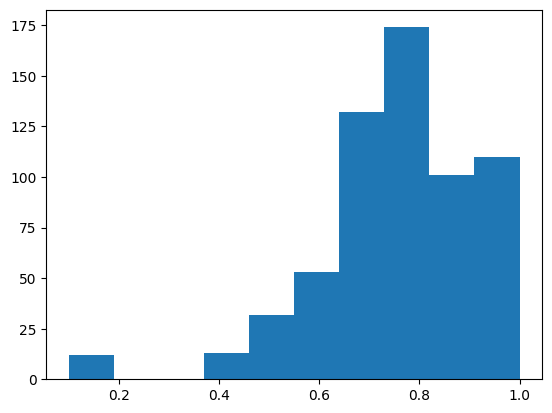

In [123]:
plt.hist(recommendation_df['score'])